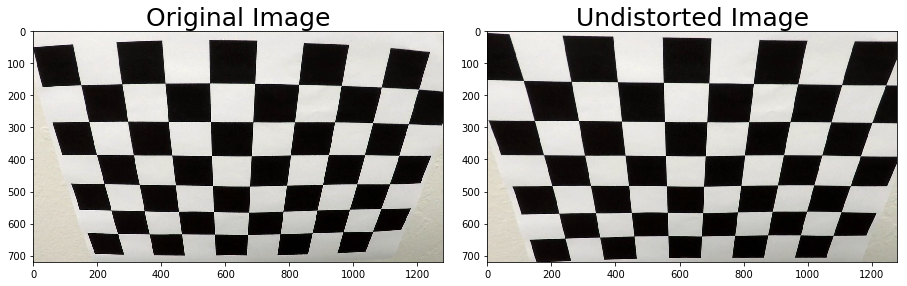

In [21]:
#################################
# Calibrate the camera
##############################

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

def calibrate_camera():
    # Returns:
    #  mtx: camera matrix
    #  dist: distortion coefficients
    
    # Read in the images
    images = glob.glob('camera_cal\calibration*.jpg')

    # Points used to calibrate the camera
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    nx = 9 # Number of corners in x direction
    ny = 6 # Number of corners in y direction

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Cycle through each image gathering points for camera calibration
    for fname in images:
        img = mpimg.imread(fname) # read the image into an numpy array

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found
        if ret == True:
            # add image points and object points
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # show undistorted images
    fname = images[10] #select an original image to display
    original_img = mpimg.imread(fname) # read the original image into an numpy array
    undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(original_img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undistorted_img)
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

    return mtx, dist

#############################
# Calibrates the camera
g_mtx, g_dist = calibrate_camera()

In [22]:
## Utility methods

# Display 2 color images side-by-side
def display_2_images(image1, image1title, image2, image2title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1title, fontsize=25)
    ax2.imshow(image2)
    ax2.set_title(image2title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
# Display 2 grayscale images side-by-side
def display_2_g_images(image1, image1title, image2, image2title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(image1title, fontsize=25)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(image2title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


In [23]:
##############################################################
# Apply distortion correction to a road image
############################################

def correct_distortion(original, mtx, dist):
    ## Applies distortion correction to a road image
    # params
    #     original: numpy array of the unchanged image
    # returns:
    #     undistorted: the original image with distortion removed
    
    undistorted = cv2.undistort(original, mtx, dist, None, mtx)

    return undistorted


In [4]:
##############################################################################################
# Use color transforms, gradients, etc., to create a thresholded binary image.
###################################################################

#########################################################
# Define gradient and color thresholding methods

# Define a function that takes an image, gradient orientation,
#   and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255): 
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:  # assume 'y'
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as the binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8-bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_S_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls_image[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_L_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls_image[:,:,1]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

########################################
# Apply thresholding
##########################

def apply_thresholding(undistorted_img, single=False):
    #  Use color transforms and gradients to create a thresholded binary image.
    
    # Input:
    #    kernel_size: Must be odd. Used in the Sobel methods. Use a larger odd number to smooth gradient measurements more.
    # Returns:
    #    combined_binary: the resulting color image of applying all the transforms to an undistorted image
    
    kernel_size=15
    
    # Apply the thresholding methods
    grad_x_binary = abs_sobel_thresh(undistorted_img, orient='x', thresh_min=20, thresh_max=100)
    grad_y_binary = abs_sobel_thresh(undistorted_img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=kernel_size, mag_thresh=(30, 200))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=kernel_size, thresh=(0.7, 1.3))
    hls_L_binary = hls_L_select(undistorted_img, thresh=(90, 175))
    hls_S_binary = hls_S_select(undistorted_img, thresh=(90, 250))

    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((grad_x_binary == 1) & (grad_y_binary == 1))
                    | ((mag_binary == 1) & (dir_binary == 1)) 
                    | ((hls_S_binary == 1) )] = 1
    
    if single == True:
        # Display thresholding images from a single image

        # Plot the Original and Combined images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undistorted_img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        # Plot the HLS L & S images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(hls_L_binary)
        ax1.set_title('Thresholded L', fontsize=50)
        ax2.imshow(hls_S_binary, cmap='gray')
        ax2.set_title('Thresholded S', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        # PLot the gradient x and y images
        display_2_g_images(grad_x_binary, 'Thresholded Gradient x',
                           grad_y_binary, 'Thresholded Gradient y')

        # Plot the magnitude and direction gradient images
        display_2_g_images(mag_binary, 'Thresholded Magnitude',
                           dir_binary, 'Thresholded Gradient Dir.')

    return combined_binary


In [5]:
#####################################################################################
# Apply a perspective transform to rectify binary image ("birds-eye view").
##############################################################

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Create the warped image -- uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    ## Only used to generate data for the report
    # Add line to original image
    #cv2.polylines(img, [np.int32(src)], 1, (255,0,0), 4)
    #cv2.polylines(warped, [np.int32(dst)], 1, (255,0,0), 4)
    #print("src: ")
    #print(src)
    #print("dst: ")
    #print(dst)
    # Run for a single image calculation
    
    return warped, Minv


In [6]:
#######################################################################
# Detect lane pixels and fit to find the lane boundary.
###############################################

def detect_lane_pixels_and_find_lane_boundary(bin_warped, single=False):
    # Take a histogram of the bottom half of the warped binary image
    histogram = np.sum(bin_warped[int(bin_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result

    # Original line:
    # out_img = np.dstack((gray_warped, gray_warped, gray_warped))*255
    out_img = 255*np.dstack((bin_warped, bin_warped, bin_warped)).astype('uint8')

    #######################################################################################33
    # DEBUG:
    #f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

    #ax1.set_title("bin_warped")
    #img1 = bin_warped
    #ax1.imshow(img1)
    #ax2.set_title("bin_warped")
    #ax2.imshow(bin_warped)
    #plt.show()

    ############################################################

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(bin_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_warped.shape[0] - (window+1)*window_height
        win_y_high = bin_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ############################################
    # Visualize the sliding window
    #########################
    if single:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        ## The following saves the image. Used to demonstrate that a 2-sized line writes boxes to the 
        #    image even if it doesn't display to the screen correctly.
        #cv2.imwrite('boxed_image3.jpg', out_img)
        plt.show()
    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx

In [12]:
##################################################################################
# Determine the curvature of the lane and vehicle position with respect to center
####################################################3

def determine_curvature_and_position(ploty, left_fit, right_fit, left_fitx, right_fitx, image, single=False):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if single:
        print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    mid_image = image.shape[1]                   
    mid_lane = 0.5*(right_fitx[0]+left_fitx[0])  # find middle of the image
    car_position = mid_lane - mid_image  # find difference between center image and car position
    car_position = car_position*xm_per_pix    # convert to meters
    
    return left_curverad, right_curverad, car_position


In [13]:
##########################################################################################
# Warp the detected lane boundaries back onto the original image.
#################################################################

def warp_lanes_onto_original_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_curverad, right_curverad, car_position):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)

    # Calculate the average radius of curvature
    curverad = (left_curverad + right_curverad)/2

    cv2.putText(result, 'Radius of Curvature {:>5.0f} meters'.format(curverad), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(result, 'Car position from center {:>3.4f} meters'.format(car_position), (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    
    ## Save the image to disk for the writeup.
    #cv2.imwrite('output_images\example_output2.jpg', result)

    return result

In [14]:
################################################################
# image processing pipeline
###############################
def process_image(i_original_color, single=False):
    # Input:
    #   original_color: the original color image to be processed
    #   single: True if procesing a single image.  This will display intermediate, debug images.
    #           False if called from the video creation routine.  Will not display intermediate images.
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Returns the final output (image where lines are drawn on lanes)
    
    i_undistorted_color = correct_distortion(i_original_color, g_mtx, g_dist)
    if single:  # if processing a single image, display the resulting images
        display_2_images(i_original_color, 'Original image', i_undistorted_color, 'Undistorted Image')
    
    if single:  # if processing a single image, tell method to display the resulting images
        i_combined_binary = apply_thresholding(i_undistorted_color, True)
    else:       # if processing a video, tell method not to display the resulting images
        i_combined_binary = apply_thresholding(i_undistorted_color, False)
    
    i_binary_warped, i_Minv = warp(i_combined_binary)
    
    if single:
        i_lanes_img, g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx = detect_lane_pixels_and_find_lane_boundary(i_binary_warped, True)
    else:
        i_lanes_img, g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx = detect_lane_pixels_and_find_lane_boundary(i_binary_warped, False)
    
    if single:
        i_left_curverad, i_right_curverad, i_car_position = determine_curvature_and_position(g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx, i_original_color, True)
    else:
        i_left_curverad, i_right_curverad, i_car_position = determine_curvature_and_position(g_ploty, g_left_fit, g_right_fit, g_left_fitx, g_right_fitx, i_original_color, False)
    
    final_image = warp_lanes_onto_original_image(i_binary_warped, i_undistorted_color, i_Minv, g_left_fitx, g_right_fitx, g_ploty, i_left_curverad, i_right_curverad, i_car_position)

    return final_image



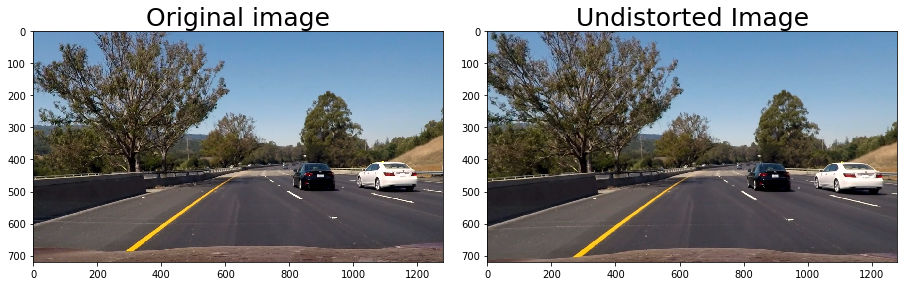

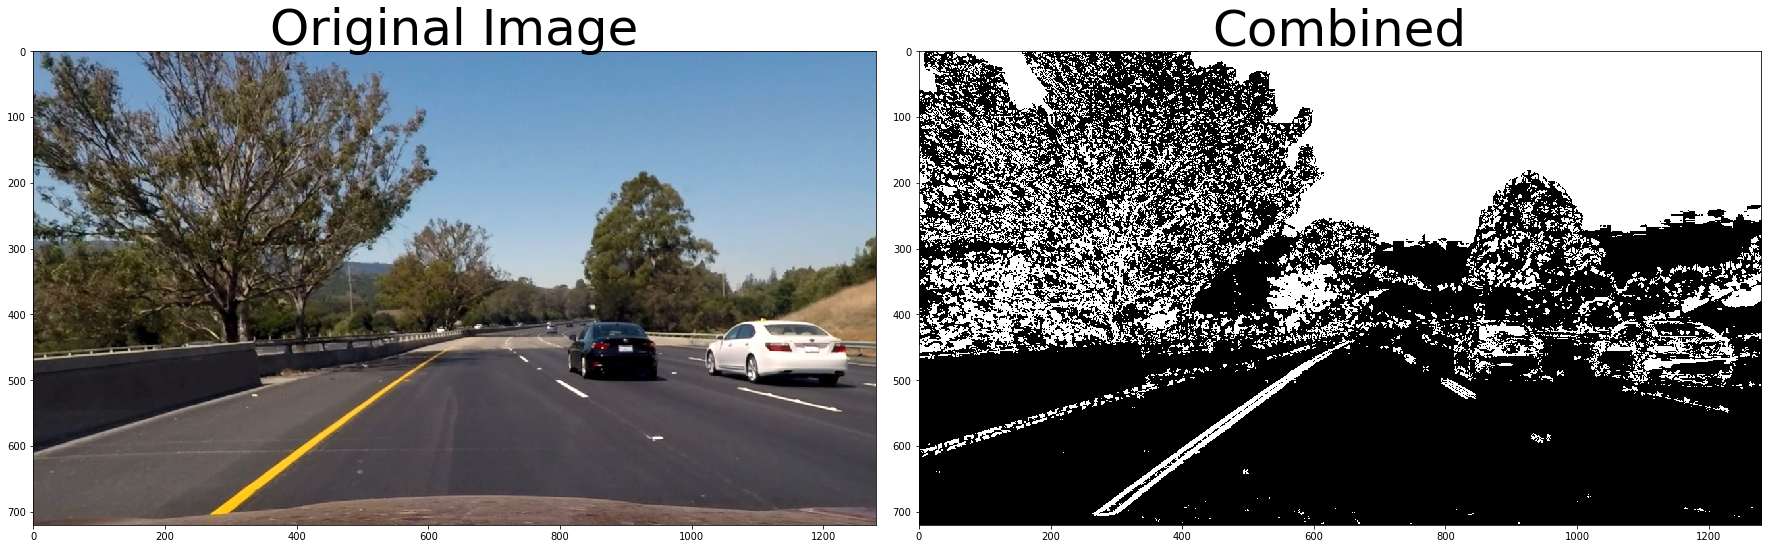

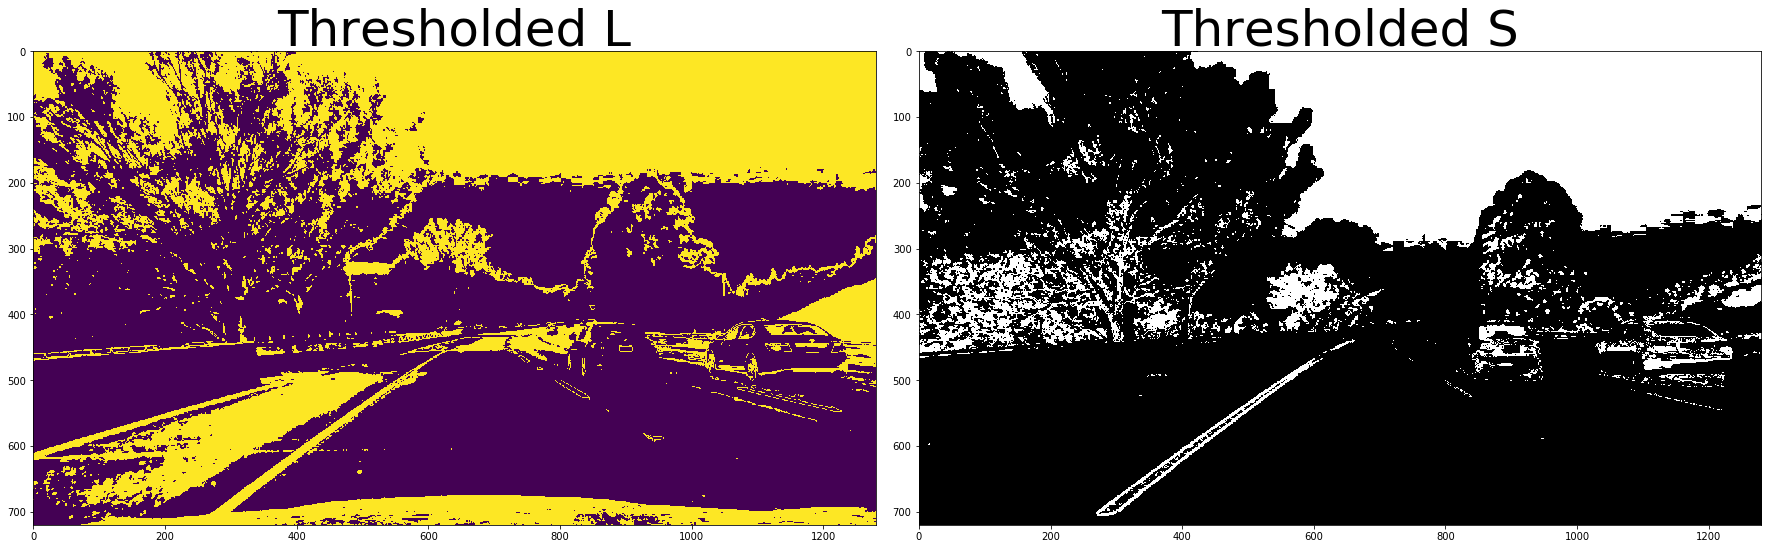

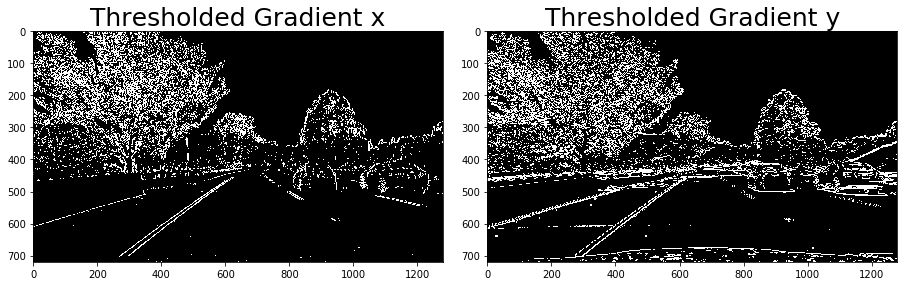

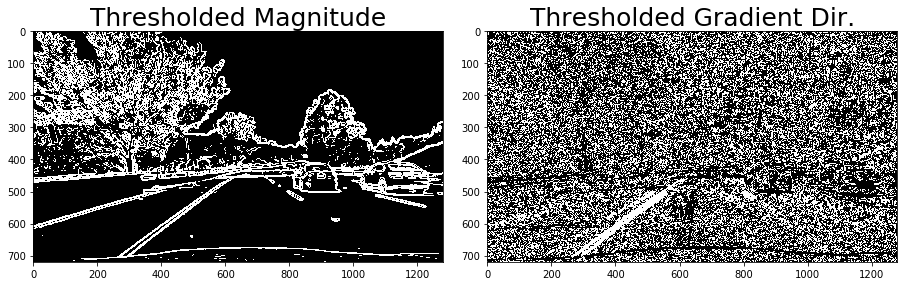

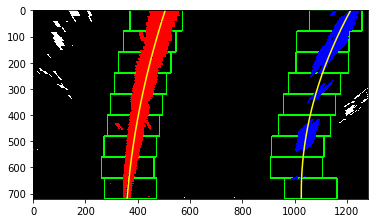

2998.29791728 1287.64292327


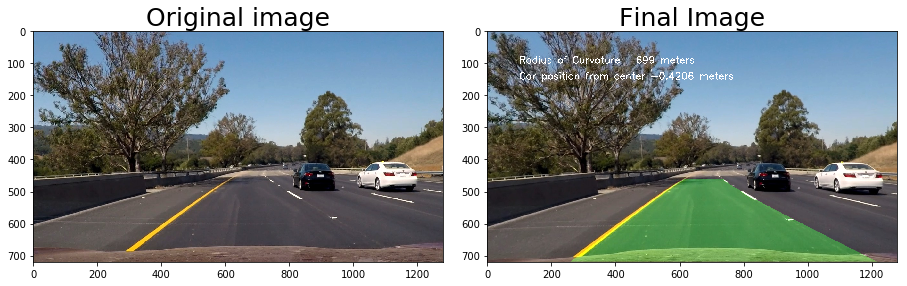

In [15]:
##################################################################
# Create a single image
###############################################
# Run for a single image calculation

# apply distortion correction for a single image
g_fname = 'test_images\\test6.jpg' # select an image to process
g_original_img = mpimg.imread(g_fname) # read the original image into an numpy array
final_img = process_image(g_original_img, True)
display_2_images(g_original_img, 'Original image', final_img, 'Final Image')

In [18]:
#################################################################
# Create a video
########################################

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [08:40<00:00,  2.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 8min 42s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))